<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/quickstart/cir_with_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composed Image Retrieval with Milvus 🖼️

This tutorial showcases the composed image search system powered by Milvus and [Visualized BGE model](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/visual). With this system, users are able to upload an image and edit text instructions, which are processed by BGE's composed retrieval model to search for candidate images.This powerful combination enables a seamless and intuitive image search experience, leveraging Milvus for efficient retrieval and BGE model for precise image processing and matching.

## Preparation

### Install Dependencies

In [1]:
!pip install --upgrade pymilvus openai datasets timm einops ftfy peft tqdm

To enable the latest codes of Visualized BGE, we will download the official repository and then install with the source code.

In [2]:
!git clone https://github.com/FlagOpen/FlagEmbedding.git
!pip install -e FlagEmbedding

> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).

### Download Data

The following command will download the example data and extract to a local folder "./images_folder" including:

- **amazon_fashion**: A subset of [Amazon Reviews 2023](https://github.com/hyp1231/AmazonReviews2023) as containing approximately 145 images from the category "Amazon_Fashion".
- **clothes.jpg**: An example query image.

In [3]:
!wget https://github.com/milvus-io/bootcamp/releases/download/data/amazon_reviews_2023_subset.tar.gz
!tar -xzf amazon_reviews_2023_subset.tar.gz

### Load Embedding Model

We will use the Visualized BGE model "bge-visualized-base-en-v1.5" to generate embeddings for both images and text. 

**1. Download weight**

In [4]:
!wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth

**2. Build encoder**

In [5]:
import torch
from FlagEmbedding.visual.modeling import Visualized_BGE


class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


model_name = "BAAI/bge-base-en-v1.5"
model_path = "./Visualized_base_en_v1.5.pth"  # Change to your own value if using a different model path
encoder = Encoder(model_name, model_path)

## Load Data

This section will load example images into the database with corresponding embeddings.

### Generate embeddings

Load all jpeg images from the data directory and apply the encoder to convert images to embeddings.

In [6]:
import os
from tqdm import tqdm
from glob import glob


# Generate embeddings for the image dataset
data_dir = (
    "./images_folder"  # Change to your own value if using a different data directory
)
image_list = glob(
    os.path.join(data_dir, "amazon_fashion", "*.jpg")
)  # We will only use images ending with ".jpg"
image_dict = {}
for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue
print("Number of encoded images:", len(image_dict))

Generating image embeddings: 100%|██████████| 145/145 [00:04<00:00, 33.11it/s]

Number of encoded images: 145


### Insert into Milvus

Insert images with corresponding paths and embeddings into Milvus collection.

> As for the argument of `MilvusClient`:
> - Setting the `uri` as a local file, e.g. `./milvus_demo.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
> - If you have large scale of data, you can set up a more performant Milvus server on [docker or kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your `uri`.
> - If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the `uri` and `token`, which correspond to the [Public Endpoint and Api key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#free-cluster-details) in Zilliz Cloud.

In [7]:
from pymilvus import MilvusClient


dim = len(list(image_dict.values())[0])
collection_name = "multimodal_rag_demo"

# Connect to Milvus client given URI
milvus_client = MilvusClient(uri="./milvus_demo.db")

# Create Milvus Collection
# By default, vector field name is "vector"
milvus_client.create_collection(
    collection_name=collection_name,
    overwrite=True,  # This will drop the old collection if exists
    auto_id=True,
    dimension=dim,
    enable_dynamic_field=True,
)

# Insert data into collection
milvus_client.insert(
    collection_name=collection_name,
    data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
)

{'insert_count': 145,
 'ids': [451500660648837120, 451500660648837121, ..., 451500660648837264],
 'cost': 0}

## Multimodal Search

Now we are ready to perform the advanced image search with query data composed of both image and text instruction.

In [10]:
query_image = os.path.join(
    data_dir, "clothes.jpg"
)  # Change to your own query image path
query_text = "black tops of this style"  # Change to your own text instruction, or None

# Generate query embedding given image and text instructions
query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
    collection_name=collection_name,
    data=[query_vec],
    output_fields=["image_path"],
    limit=9,  # Max number of search results to return
    search_params={"metric_type": "COSINE", "params": {}},  # Search parameters
)[0]

**Display search results**

Retrieved images will be displayed in the form of a 5x5 grid.

Query image:


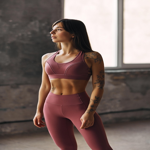

Instruction: black tops of this style

Search Results:


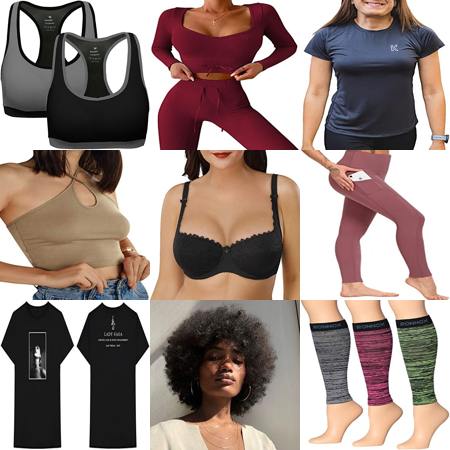

In [11]:
from PIL import Image
from IPython.display import display


print("Query image:")
query_image = Image.open(query_image)
query_image = query_image.resize((150, 150))
query_image.show()

print("Instruction:", query_text)

print("\nSearch Results:")
images = []
for hit in search_results:
    image_path = hit.get("entity").get("image_path")
    img = Image.open(image_path)
    img = img.resize((150, 150))
    images.append(img)

width = 150 * 3
height = 150 * 3
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 3
    y = idx // 3
    concatenated_image.paste(img, (x * 150, y * 150))
display(concatenated_image)

## Quick Deploy

To learn about how to start an online demo with this tutorial, please refer to [the example application](https://github.com/milvus-io/bootcamp/tree/master/bootcamp/tutorials/quickstart/apps/cir_with_milvus).

<img src="https://raw.githubusercontent.com/milvus-io/bootcamp/master/bootcamp/tutorials/quickstart/apps/cir_with_milvus/pics/cir_demo.jpg"/>